<a href="https://colab.research.google.com/github/Madhav-Somanath/SBSPS-Challenge-693-Predicting-The-Energy-Output-of-Wind-Turbine-Based-on-Weather-Condition/blob/master/Data_Prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from numpy import array
from numpy import hstack

In [18]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [19]:
import types
import pandas as pd

df= pd.read_csv('/content/data.csv')
df

,Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction,end_date,maxtempC,windGustKmph,DewPointC,windChillC,humidity,precipMM,pressure,LV ActivePower
0,5.311336,416.328908,259.994904,2018-01-01 00:00:00,10.0,11.125000,2.208333,6.333333,69.916667,0.0,1017.625000,380.047791
1,5.672167,519.917511,268.641113,2018-01-01 00:10:00,10.0,11.125000,2.208333,6.333333,69.916667,0.0,1017.625000,453.769196
2,5.216037,390.900016,272.564789,2018-01-01 00:20:00,10.0,11.125000,2.208333,6.333333,69.916667,0.0,1017.625000,306.376587
3,5.659674,516.127569,271.258087,2018-01-01 00:30:00,10.0,11.125000,2.208333,6.333333,69.916667,0.0,1017.625000,419.645905
4,5.577941,491.702972,265.674286,2018-01-01 00:40:00,10.0,11.125000,2.208333,6.333333,69.916667,0.0,1017.625000,380.650696
...,...,...,...,...,...,...,...,...,...,...,...,...
50525,11.404030,3397.190793,80.502724,2018-12-31 23:10:00,7.0,15.666667,-0.708333,1.333333,72.166667,0.0,1023.708333,2963.980957
50526,7.332648,1173.055771,84.062599,2018-12-31 23:20:00,7.0,15.666667,-0.708333,1.333333,72.166667,0.0,1023.708333,1684.353027
50527,8.435358,1788.284755,84.742500,2018-12-31 23:30:00,7.0,15.666667,-0.708333,1.333333,72.166667,0.0,1023.708333,2201.106934
50528,9.421366,2418.382503,84.297913,2018-12-31 23:40:00,7.0,15.666667,-0.708333,1.333333,72.166667,0.0,1023.708333,2515.694092


In [20]:
df.drop("end_date", axis = 1, inplace = True)
df.shape

(50530, 11)

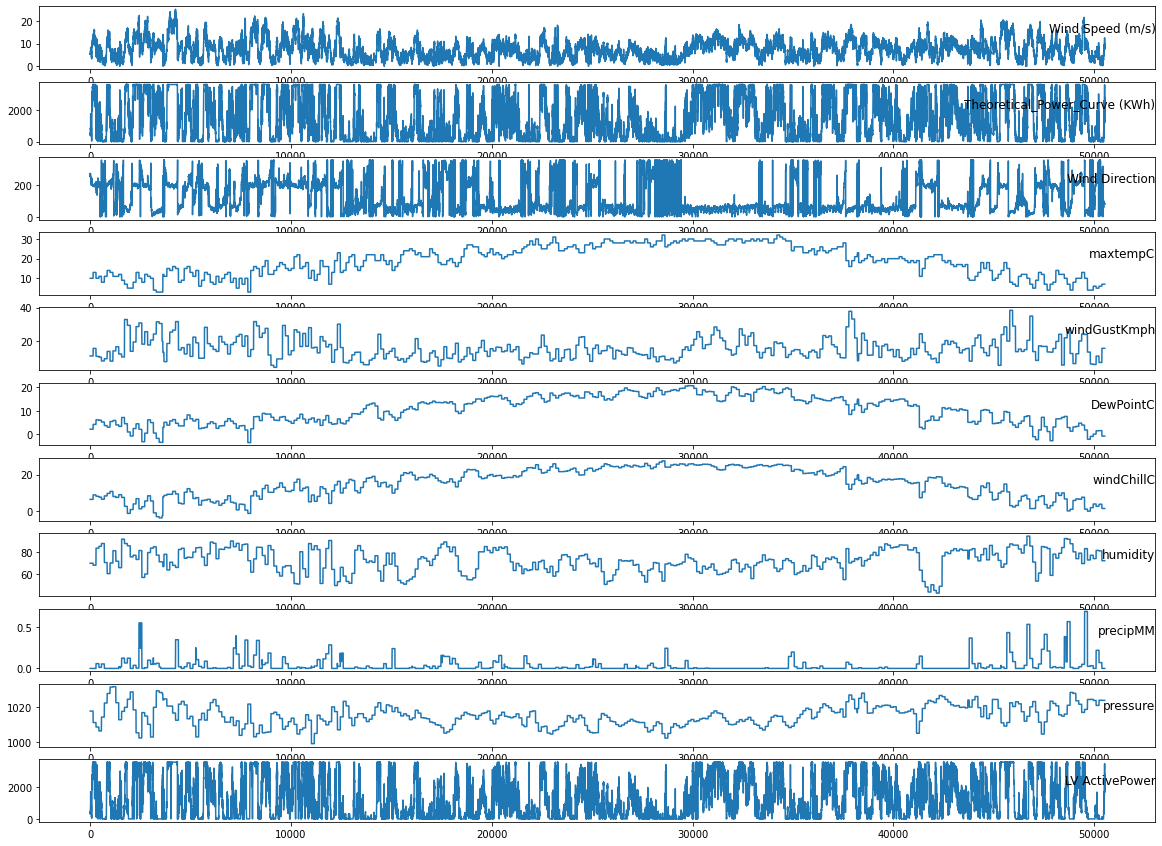

In [21]:
from matplotlib import pyplot 
# load dataset
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
i = 1
# plot each column
pyplot.figure(figsize=(20, 15))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [22]:
train_data = df.values[:40000, :]
test_data = df.values[40000:, :]

In [23]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))

scaled_train_data = sc.fit_transform(train_data)
scaled_test_data = sc.transform(test_data)

In [24]:
n_steps_in = 144
n_steps_out = 72
X, y = split_sequences(scaled_train_data, n_steps_in=n_steps_in, n_steps_out=n_steps_out)

In [25]:
X.shape, y.shape

((39786, 144, 10), (39786, 72))

In [26]:
n_features = X.shape[2]

In [27]:
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dropout

In [28]:
# define model
model = Sequential()

model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate = 0.2))
model.add(Dense(n_steps_out))

In [29]:
model.compile(optimizer='adam', loss='mse')

In [30]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
  
    def on_batch_end(self, batch, logs = {}):
        self.losses.append(logs.get('loss'))

history = LossHistory()

In [31]:
# define the checkpoint
filepath = "model_with_2lstm100_1dense128_dropout0.25_layers.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, history]

In [33]:
model_history = model.fit(X, y, batch_size=72, epochs = 10, validation_split=0.15, shuffle = False, verbose = 1, callbacks=callbacks_list)

Epoch 1/10
470/470 [==============================] - ETA: 0s - loss: 0.0793
Epoch 00001: loss improved from 0.10150 to 0.07925, saving model to model_with_2lstm100_1dense128_dropout0.25_layers.h5
470/470 [==============================] - 291s 619ms/step - loss: 0.0793 - val_loss: 0.0640
Epoch 2/10
470/470 [==============================] - ETA: 0s - loss: 0.0736
Epoch 00002: loss improved from 0.07925 to 0.07356, saving model to model_with_2lstm100_1dense128_dropout0.25_layers.h5
470/470 [==============================] - 292s 620ms/step - loss: 0.0736 - val_loss: 0.0615
Epoch 3/10
470/470 [==============================] - ETA: 0s - loss: nan
Epoch 00003: loss did not improve from 0.07356
470/470 [==============================] - 291s 618ms/step - loss: nan - val_loss: nan
Epoch 4/10
470/470 [==============================] - ETA: 0s - loss: nan
Epoch 00004: loss did not improve from 0.07356
470/470 [==============================] - 290s 616ms/step - loss: nan - val_loss: nan
Epoc